# Trajectory Optimization using Direct Collocation

### CS/ECE/ISyE 524 — Introduction to Optimization — Spring 2018  
Alex Dawson-Elli  
Patrick Dills  
Kieran Nichols



### Table of Contents  

* [Introduction](#introduction)  
* [Mathematical modeling](#mathematicalModel)  
* [Exploration of Modeling Assumptions](#assumptions)  
    * [small angles and quazi-static assumptions](#1a)  
    * [small angles assumption](#1b)  
    * [full dynamics](#1c)  
    * [results and discussion](#1RD)
* [Experimentation with Full Dynamics](#2)   
    * [Obsticle avoidance with hard constraints](#2aa)  
    * [Obsticle avoidance with regularization](#2ab)  
    * [Double pendulum swing up](#2b)  
* [Conclusion](#conclusion)  


# Introduction <a class="anchor" id="introduction"></a>

As Mechanical Engineers, we were inspired to gain new insight into a cannonical controls problem though optimization techniques learned in 524. In this report, we develop optimal trajectories for a cart-pole system. The system being modeled consists of a cart and a point mass pendulum. The cart of mass ($m_1$) lays on a frictionless track and can be moved horizontally by control force ($u$). The pendulum with a massless rod (length, $l$) and a bob (mass, $m_2$) is attached to the cart by a frictionless bearing. Because of it's inertia, the force acting on the cart will also cause the pendulum to swing.

<img src="./gifs/cartSchematic.PNG " style="width: 550px;"/>[1]

This class of problem, know as trajectory optimization, has its roots in the Brachistochrone problem posed by Johann Bernoulli in 1697.[2] Brachistochrone problem is to find the path of a ball down a slope which reaches the end in the shoretest time. The form of the problem is particularly difficult because it requires optimizing over the set of functions as opposed to optimizing over a variable. To solve in closed form, this required the development of calculus of variation, and is impractical for all but the simplest problems. Modern computers have made the solution of more complex problems trajectory optimization problems possible with applications ranging from computing the paths of rockets to walking robots.[3]

The control problem to be solved may be stated as follows: generate a control signal ($u$) that when applied to the system brings it from an initial configuration (or state) $x_0$  to a desired configuration $x_f$, in the prescribed amount of time. There are infinitely many ways to accomplish this task, but not every trajectory is desirable. For reasons such as reducing component wear, reducing power consumption and increaseing soothness of the path, the heuristics such as minimizing total energy and minimizing sum of the squared force have been used [citation]. In this investigation, we will minimize the square of control force ($u^2$) 

In this investigation, we first present a mathematical derivation of the cart-pole dynamics, and standard form of our models. In the [Exploration of Modeling Assumptions](#assumptions) section we develop 3 models of the same system each of which makes different simplifying assumptions. The assumptions make the problem easier to solve - in the first case this is even enough to change the problem type - at the expense of model fidelity. In the [results and discussion](#1RD) section we use three test problems to explore where assumptions are valid and where they break down. 

In the final section we investigate the ability of the full dynamics model to swing up the pendulum (from non- inverted to inverted) while avoiding obstacles using either explit (hard) constraints or regularization (soft constraints). We then develop a model of a double pendulum (cart, two rods, and two bobs) and solve swing up for that system. 

citations:

[1]Kelly, Matthew. "An Introduction to Trajectory Optimization: How to Do Your Own Direct Collocation." SIAM Review 59.4 (2017): 849-904. 

[2]300 Years of Optimal Control: From The Brachystochrone to the Maximum Principle, Hector J. Sussmann and Jan C. Willems. IEEE Control Systems, 1997.  

[3]Posa, Michael, and Russ Tedrake. "Direct trajectory optimization of rigid body dynamical systems through contact." Algorithmic Foundations of Robotics X. Springer, Berlin, Heidelberg, 2013. 527-542  



# Mathematical modeling <a class="anchor" id="mathematicalModel"></a>

Cartesian coordinates of the cart and pole will be 
\begin{equation}
\begin{bmatrix}
q_1 \\ 0 
\end{bmatrix}
\qquad \text{and} \qquad 
\begin{bmatrix}
q_1 + l \sin(q_2) \\ l \cos(q_2)] 
\end{bmatrix}
\end{equation}
where ($q_1$) is the horizontal position of the cart and ($q_2$) is the angle of the pendulum.

The state, $x$ and state derivative, $\dot{x}$ will give the dynamics of the system in first-order form and represnets the minimal generalized coordinates and its derivatives
\begin{equation}
 x =
 \begin{bmatrix}
  q_1 \\ q_2 \\ \dot{q_1} \\ \dot{q_2}
\end{bmatrix}	
\qquad \text{and} \qquad 		
\dot{x} = f ( x , u ) =
\begin{bmatrix}
\dot{q_1} \\ \dot{q_2} \\ \ddot{q_1} \\ \ddot{q_2}
\end{bmatrix}
\end{equation}

Using Lagrangian method, 	
$ L = T - V $
where T is the kinetic energy and V the potential energy of the system. L summarizes the system dynamics.

\begin{align}
& T = T_{cart} + T_{pole} \\
&T_{cart} = \frac{1}{2} m_1\dot{ q_1}^2 \\
&T_{pole} = \frac{1}{2} m_2  [\dot{(q_1 + l \sin(q_2)}^2 +\dot{(l\cos(q_2)}^2] \\\\
& V = V_{cart} + V_{pole} \\
&V = 0 + m_2 g l \cos(q_2) \\
\end{align}

The potential energy of the cart is zero since it is not moving vertically and it has a height of 0.

Thus $L = \frac{1}{2} m_1 q_1^2 + \frac{1}{2} m_2 [\dot{(x + l \sin(q_2)}^2 +\dot{(l\cos(q_2)}^2] - m_2 g l \cos(q_2)$


The generalized coordinates could be defined as 
\begin{equation}	
X = 
\begin{bmatrix}
q_1  \\ q_2 
\end{bmatrix}
\end{equation}
To yield the equations of motion for the cart/pendulum system, the Lagrangian equations will: 
\begin{align}
&\frac{d}{dt}(\frac{\partial L}{\partial{\dot{q_1}}}) - \frac{\partial L}{\partial{\dot{q_1}}} = u \\
&\frac{d}{dt}(\frac{\partial L}{\partial{\dot{q_2}}}) - \frac{\partial L}{\partial{\dot{q_2}}} = 0
\end{align}

Solving for the partial and time derivatives will yield
\begin{align}
&(m_1 + m_2) \ddot{q_1} + m_1 l \ddot{q_2} \cos(q_2) - m_2 l \dot{q_2}^2 \sin(q_2) = u \\
&m_2 l \ddot{q_1} \cos(q_2) + m_2 l^2 \ddot{q_2}  - m_2 g l \sin(q_2) = 0 
\end{align}
The detailed derivations of the derivatives can be found on this <a href=\"http://www.aoengr.com/Dynamics/PendulumOnCart.pdf\">webisite.</a> 

Rearranging the above equations and solving for the $\ddot{q_1}$ and $\ddot{q_2} $ terms respectively,
\begin{align}
&\ddot{q_1} = \frac{ l m_2 \sin(q_2) \dot{q_2}^2 + u + m_{2} g \cos(q_{2}) sin(q_2)} {m_1 + m_2\sin^2(q_2)} \\
&\ddot{q_2} = \frac{ l m_2 \cos(q_2) \sin(q_2^2) \dot{q_2}^2 + u \cos(q_2) + (m_1 + m_2) g \sin(q_2)} {l (m_1 + m_2\sin^2(q_2))}
\end{align}

The objective fuction will be the continuous integral of the actuator effort (control force) squared:		
\begin{equation}
\min_{u(t)} \int_{t_{initial}}^{t_{final}} u^2 ( t ) d t
\end{equation}

The above obejective function is a problem with vector functions as decision variables subject to diffrential equations as constraints. A Transcription process will be used in this project to create a constrained parameter optimization with real numbers as the decision variables that will contain algebraic equations. The continuous time and diffrential equations will be converted to discrete sets of real numbers by direct collocation where time will be broken into a number of gridpoints (size N).

\begin{align}
% & k \in \{1,\dots,N\}\\
&t_k = {t_0, \dots, t_N}\\
& x_k = x(t_k)\\
& \dot{x_k} = \dot{x}(t_k)\\
& u_k = u(t_k)\\
& h_k = t_{n+1} - t_n
\end{align}

To estimate future state and state derivatives ($x_k$ and $\dot{x_k}$), a trapezoidal method will be used where

\begin{align}
&\int_{t_{initial}}^{t_{final}} x ( t ) dt \approx \sum_{k = 0}^{N-1} \frac{h_k}{2} (\dot{x_k} + \dot{x_{k+1}})
\end{align}

With the direct collocation, the objective fuction will be the sum of the control force from intial to final step.
\begin{equation}
\min_{u(t)} \int_{t_{initial}}^{t_{final}} u^2 ( t ) dt \approx \min_{u(k)} \sum_{k = 0}^{N} u_k^2 
\end{equation}

Restating this optimization problem in discrete standard form will yield
\begin{align}
\underset{u_k \in {R^2}}{\text{minimize}}\qquad& \sum_{k=1}^{N} u_k^2\\
& {x_k} - {x_k}_{initial} = 0 && \forall k \in \{1,\dots,k-1\}\\
& {\dot{x_k}} - {\dot{x_k}}_{final} = 0 && \forall k \in \{1,\dots,k-1\}\\
& {x}_{k+1} - {x}_{k} - 0.5 h ({\dot x}_{k} -{\dot x}_{k+1}) = 0 && \forall k \in \{1,\dots,k-1\}\\
%	& \mathbf{\dot{x}}_{k+1} - \mathbf{\dot{x}}_{k} - 
%	= 0 &&\forall k \in \{1,\dots,k-1\}\\
\end{align}


# Exploration of Modeling Assumptions <a class="anchor" id="assumptions"></a>


### Small Angle Assumption and quazi-static assumptions  <a class="anchor" id="1a"></a>

#### description of modeling assumption here!!!

In [87]:
using JuMP, Gurobi
"""
linearize the dynamics of the cart pull mechanism through the small angle assumption -> first term
in taylor series expansion for sin(q) and cos(q) and quazi-static assumption

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolvLinearizedCartPole(x0, xf, tf, h ; q2const = false , itype = "Trap")
    
    #define model
    m = Model(solver = GurobiSolver(OutputFlag=0))
    T = 0:h:tf                   #time vector
    K = length(T)                 #number of collocation points
    @variable(m,    x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)
    
    #path constraints
    #q₂ limit
    if q2const
        for k in 1:K
            @constraint(m, x[2,k] >= xf[2,1] - pi/2)
            @constraint(m, x[2,k] <= xf[2,1] + pi/2)
        end
    end
    
    
    #q₁ limits
#     for k in 1:K
#         @constraint(m, x[1,k] >= -10)
#         @constraint(m, x[1,k] <=  10)
#     end
        
    #dynamics (path) constraints, integral form
    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    linAngle = 0 #the q2 angle we linearize the system about 
    
    
    #setup the dynamics constraints linearized about q1 = 0
    if linAngle == 0
        for k in 1:K
            #notes - linearized system with first term in taylor series, and neglected coreolis acceleration
            @constraint(m,xdot[1,k] == x[3,k])
            @constraint(m,xdot[2,k] == x[4,k])
            @constraint(m,xdot[3,k] == u[1,k] + m2*g*1*x[2,k] / m1) 
            @constraint(m,xdot[4,k] == -u[1,k]  -(m1 + m2)*g*x[2,k] / m1) 

        end
    end
    
    if linAngle == pi
        for k in 1:K
            #notes - linearized system with first term in taylor series, and neglected coreolis acceleration
            @constraint(m,xdot[1,k] == x[3,k])
            @constraint(m,xdot[2,k] == x[4,k])
            @constraint(m,xdot[3,k] == u[1,k]  + m2*g*1*x[2,k] / m1) 
            @constraint(m,xdot[4,k] == u[1,k]  +(m1 + m2)*g*x[2,k] / m1) 

        end
    end

    if itype == "forwardEuler" 
        #add forward euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + h*xdot[:,k])
        end
        
    elseif itype == "Trap"
        for k in 1:K-1
             #add backwards euler dynamics constraint
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end
    
    
    # minimize 2-norm (THIS IS LEAST-SQUARES)
    @objective(m, Min, sum(u.^2) ) #+ sum(x[2,:]).^2))
    solve(m)
    #print(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    return (control, xopt,xdotopt)
end
 

SolvLinearizedCartPole

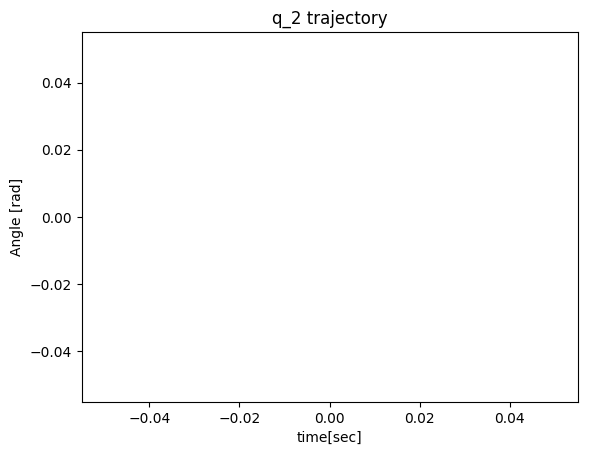

Academic license - for non-commercial use only


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000051F06B38>

In [250]:
#define initial and final states
x0 = [0 pi 0 0]' 
xf = [3 pi 0 0]' 
tf = 3 ; h = .05

#evaluate each model
u1,x1,xdot1 =  SolvLinearizedCartPole(x0, xf, tf, h ; q2const = true , itype = "Trap")
#u1,x1,xdot1 = SolvFullCartPole(x0, xf, tf, h ; q2const = true , itype = "Trap")
plotq2(x1,h,tf)

### Small Angle Assumption  <a class="anchor" id="1b"></a>

In this section the complexity of dynamic constraints are increased in an attempt to obtain a more accurate solution to the swing up problem. The small angle assumption is still made to simplify the model. However, the effect of centripetal acceleration on the optimization is included.

Small Angle Assumption:
$$ cos(q_2) \approx 1 $$
$$ sin(q_2) \approx q_2 $$

Centripetal Acceleration:
$$ \alpha = lm_2\dot q_2^2 $$

This simplification removes the trigonometric functions from the dynamic constraints and is usually considered valid for angles of less than 10 degrees about the angle of linearization.

The simplified dynamic constraints for the optimization are:
$$ \ddot q_1 = \frac{lm_2sin(q_2)\dot q_2^2 + u + m_2gcos(q_2)sin(q_2)}{m_1 + m_2(1-cos^2(q_2))} \approx \frac{lm_2q_2\dot q_2^2 + u + m_2gq_2}{m_1} $$
$$ \ddot q_2 = - \frac{lm_2cos(q_2)sin(q_2)\dot q_2^2 + ucos(q_2) + (m_1+m_2)gsin(q_2)}{lm_1 + lm_2(1-cos^2(q_2))} \approx - \frac{lm_2q_2\dot q_2^2 + u + (m_1+m_2)gq_2}{lm_1} $$

Both sets of constraints are non-linear and are not able to be expressed in a quadratic or second order cone form because of centripetal acceleration terms, $lm_2q_2\dot q_2^2$, in each of the equations. This forces us to approach the optimization problem with a nonlinear solver like "Ipopt".


### Standard Form
\begin{aligned}
\underset{\mathbf{x},\mathbf{\dot x},\mathbf{u}_i \in \mathbb{R^2}}{\text{minimize}}\qquad& \sum_{i=1}^{n}u_i^2\\
\text{subject to:}\qquad & {x_{1}} - {x}_{initial} = 0 \\
& {\dot{x_{k}}} - {\dot{x}}_{final} = 0 && \\
& \ddot q_1 - \frac{lm_2q_2\dot q_2^2 + u + m_2gq_2}{m_1} = 0 && \forall k \in \{1,\dots,N\}\\
&  \ddot q_2 + \frac{lm_2q_2\dot q_2^2 + u + (m_1+m_2)gq_2}{lm_1} =  0 && \forall k \in \{1,\dots,N\}\\
& {x}_{k+1} - {x}_{k} - 0.5 h ({\dot x}_{k} +{\dot x}_{k+1}) = 0 && \forall k \in \{1,\dots,N-1\}\\
& \text{where:}\\
& \begin{equation}
 x =
 \begin{bmatrix}
  q_1 \\ q_2 \\ \dot{q_1} \\ \dot{q_2}
\end{bmatrix}	
\qquad \text{and} \qquad 		
\dot{x} = f ( x , u ) =
\begin{bmatrix}
\dot{q_1} \\ \dot{q_2} \\ \ddot{q_1} \\ \ddot{q_2}
\end{bmatrix}
\end{equation}
\end{aligned}

In [81]:
using JuMP, Ipopt

"""
simplify the dynamics of the cart pull mechanism through the small angle assumption -> first term
in taylor series expansion for sin(q) and cos(q)

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolvNonStaticCartPole(x0, xf, tf, h ; q2const = false,  itype = "Trap")
    
    #define model
    #m = Model(solver = GurobiSolver(OutputFlag=0))
    m = Model(solver = IpoptSolver(print_level=0))
    T = 0:h:tf                    #time vector
    K = length(T)                 #number of collocation points
    @variable(m,    x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)
    
    
    #path constraints
    #q₂ limit
    if q2const
        for k in 1:K
            @constraint(m, x[2,k] >= xf[2,1] - pi/2)
            @constraint(m, x[2,k] <= xf[2,1] + pi/2)
        end
    end
    
    #q₁ limits
    for k in 1:K
        @constraint(m, x[1,k] >= -4)
        @constraint(m, x[1,k] <=  4)
    end
        
    
    #dynamics (path) constraints, integral form
    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    linAngle = 0
    
    #setup the dynamics constraints linearized about q1 = 0
    if linAngle == 0
        for k in 1:K
            #notes - linearized system with first term in taylor series
            @constraint(m,xdot[1,k] == x[3,k])
            @constraint(m,xdot[2,k] == x[4,k])
            
            q1 = x[1,k] ; q2 = x[2,k] ; q1dot = x[3,k] ; q2dot = x[4,k]
            @NLconstraint(m,xdot[3,k] == (l*m2*q2*q2dot^2 + u[1,k] + m2*g*1*q2) / m1)
            @NLconstraint(m,xdot[4,k] == -(l*m2*1*q2*q2dot^2 + u[1,k]*1 + (m1 + m2)*g*q2) / l*m1) 
        end
    end
    
    if linAngle == pi
        for k in 1:K
            #notes - linearized system with first term in taylor series
            @constraint(m,xdot[1,k] == x[3,k])
            @constraint(m,xdot[2,k] == x[4,k])
            
            q1 = x[1,k] ; q2 = x[2,k] ; q1dot = x[3,k] ; q2dot = x[4,k]
            @NLconstraint(m,xdot[3,k] == (l*m2*q2*q2dot^2 + u[1,k] + m2*g*1*q2) / m1)
            @NLconstraint(m,xdot[4,k] == -(l*m2*1*q2*q2dot^2 - u[1,k]*1 -(m1 + m2)*g*q2) / l*m1) 

        end
    end
    
    if itype == "forwardEuler" 
        #add forward euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + h*xdot[:,k])
        end
        
    elseif itype == "Trap"
        #add backwards euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end
    
    # minimize 2-norm (THIS IS LEAST-SQUARES)
    #@objective(m, Min, .5*h*sum(u[1:end-1].^2 + u[2:end].^2))
    @objective(m, Min, sum(u.^2)) 
    solve(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    return (control, xopt, xdotopt)
end

SolvNonStaticCartPole

### Full Dynamics <a class="anchor" id="1c"></a>
The full dynamic model for a single pendulum is used in this section. There are no simplifying assumptions made to simplify the constraints and a nonlinear solver with nonlinear constraints are necesarry.

### Standard Form
\begin{aligned}
\underset{\mathbf{x},\mathbf{\dot x},\mathbf{u}_i \in \mathbb{R^2}}{\text{minimize}}\qquad& \sum_{i=1}^{n}u_i^2\\
\text{subject to:}\qquad & {x_{1}} - {x}_{initial} = 0 \\
& {\dot{x_{k}}} - {\dot{x}}_{final} = 0 && \\
& \ddot q_1 - \frac{lm_2sin(q_2)\dot q_2^2 + u + m_2gcos(q_2)sin(q_2)}{m_1 + m_2(1-cos^2(q_2))} = 0 && \forall k \in \{1,\dots,N\}\\
& \ddot q_2 + \frac{lm_2cos(q_2)sin(q_2)\dot q_2^2 + ucos(q_2) + (m_1+m_2)gsin(q_2)}{lm_1 + lm_2(1-cos^2(q_2))} =  0 && \forall k \in \{1,\dots,N\}\\
& {x}_{k+1} - {x}_{k} - 0.5 h ({\dot x}_{k} +{\dot x}_{k+1}) = 0 && \forall k \in \{1,\dots,N-1\}\\
& \text{where:}\\
& \begin{equation}
 x =
 \begin{bmatrix}
  q_1 \\ q_2 \\ \dot{q_1} \\ \dot{q_2}
\end{bmatrix}	
\qquad \text{and} \qquad 		
\dot{x} = f ( x , u ) =
\begin{bmatrix}
\dot{q_1} \\ \dot{q_2} \\ \ddot{q_1} \\ \ddot{q_2}
\end{bmatrix}
\end{equation}
\end{aligned}

In [80]:
using JuMP, PyPlot, Ipopt

#define initial and final states, x
x0 = [0 0 0 0]' 
xf = [3 pi 0 0]'   #wind up at the same angle, but 

"""
solve the cart pole problem with and full dynamics

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolvFullCartPole(x0, xf, tf, h; q2const = false, xStart="None" , itype="Trap")
    
    #define model
    m = Model(solver = IpoptSolver(print_level=0))
    T = 0:h:tf                   #time vector
    K = length(T)                 #number of collocation points
    @variable(m, x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1
    if xStart != "None"  setvalue(x[:,:] , xStart) end

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)

    #path constraints
    if q2const
        for k in 1:K
            @constraint(m, x[2,k] >= xf[2,1] - pi/2)
            @constraint(m, x[2,k] <= xf[2,1] + pi/2)
        end
    end
    
      for k in 1:K
        @constraint(m, x[1,k] >= -10)
        @constraint(m, x[1,k] <=  10)
    end
    
    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    
    
    #setup the full dynamics constraints
    for k in 1:K
        @constraint(m,xdot[1,k] == x[3,k])                      
        @constraint(m,xdot[2,k] == x[4,k])                         
        q1 = x[1,k] ; q2 = x[2,k] ; q1dot = x[3,k] ; q2dot = x[4,k]
        @NLconstraint(m,xdot[3,k] ==  (l*m2*sin(q2)*q2dot^2 + u[1,k] + m2*g*cos(q2)*sin(q2)) /
                                    (m1 + m2*(1-cos(q2)^2)))
        @NLconstraint(m,xdot[4,k] == -(l*m2*cos(q2)*sin(q2)*q2dot^2 + u[1,k]*cos(q2) + (m1 + m2)*g*sin(q2))/
                                    (l*m1 + l*m2*(1-cos(q2)^2)))
    end
    

    if itype == "forwardEuler" 
        #add forward euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + h*xdot[:,k])
        end
        
    elseif itype == "Trap"
        for k in 1:K-1
             #add backwards euler dynamics constraint
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    #@objective(m, Min, .5*h*sum(u[1:end-1].^2 + u[2:end].^2))
    @objective(m, Min, sum(u.^2) ) # + 10000*sum(x[2,:] - pi).^2)
    solve(m)
    #print(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    return (control, xopt, xdotopt)
end


SolvFullCartPole

### Results and discussion <a class="anchor" id="RD1"></a>

For each test case, we examine the solution of each model and analyse where a model is valid or invalid and why. Below we define a set of plotting routines that will be used in the course of our analysis.  


In [104]:
using PyPlot

# Plotting the output of the Optimization in q coords and effort
function plotq2(x,h,tf)
    #figure(figsize=(12,4))
    title("q_2 trajectory")
    xlabel("time[sec]")
    ylabel("Angle [rad]")
    t = 0:h:tf
    plot( t, x[2,:], markersize = 2)
end

function plotq1(x,h,tf)
    title("q_1 trajectory")
    xlabel("time[sec]")
    ylabel("Distance [m]")
    t = 0:h:tf
    plot( t, x[1,:], markersize = 2)
end

function plotu(u,h,tf)
    title("Optimization Output Effort")
    xlabel("time[sec]")
    ylabel("Force [N]")
    plot(u[1,:])
end

# plotting the cart and pendulum position at each collocation point
function plotTipTraj(x)
    #Transform to x and y coordinates of the mass location
    l = 1
    K = size(x)[2]
    xCordM = zeros(1,K)
    yCordM = zeros(1,K)
    
    xCordM = x[1,:] + l*sin.(x[2,:])
    yCordM = -l*cos.(x[2,:])
    
    #xCordM = x[1,:] + l*cos.(x[2,:] + (pi/2))
    #yCordM = -l*sin.(x[2,:] + (pi/2))
    
    title("trajectory of tip in xy plane ")
    xlabel("Meters")
    ylabel("Meters")
    plot( xCordM, yCordM,".", markersize = 2)
end

# Plotting a stem plot of the cart and pendulum position at each colocation point
function plotXY(x)
    l = 1
    K = size(x)[2]
    
    # Transform to x and y coordinates of the tip location
    xCordM = zeros(1,K)
    yCordM = zeros(1,K)
    xCordM = x[1,:] + l*sin.(x[2,:])
    yCordM = -l*cos.(x[2,:])
    
    # Transform to x and y coordinates of the Cart
    xCordC = zeros(1,K)
    yCordC = zeros(1,K)
    xCordC = x[1,:]'
    
    #figure(figsize=(12,4))
    title("XY Transform of Colocation Results ")
    xlabel("Meters")
    ylabel("Meters")
    plot( xCordM, yCordM,".", markersize = 20);
    plot( xCordC, yCordC,"rs", markersize = 15);
    #legend(["Mass Location","Cart Location"])
    for i =1:length(xCordM)
     plot( [xCordM[i],xCordC[i]] , [yCordM[i], yCordC[i]],"k");
    end
end

function plotContour(xoff,yoff)
    xv = linspace(-6,4,1000)
    yv = linspace(-1.1,1.1,1000)
    function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
        m, n = length(vy), length(vx)
        vx = reshape(vx, 1, n)
        vy = reshape(vy, m, 1)
        (repmat(vx, m, 1), repmat(vy, 1, n))
    end
    (X,Y) = meshgrid(xv,yv);

    z = [1/(sqrt(2*pi*sig^2))*exp(-((x-xoff)^2 + (y-yoff)^2)/(2*sig^2)) for y in yv, x in xv]
    contour(X, Y, z, zdir="z", 60, offset=0, linewidths=.5 );
end

# Plotting the Ellipse Constraining the motion of the pendulum
function plotEllipse(a,b,c,xoff,yoff) 
    angle = linspace(0,2*3.14595,360);
    r = zeros(1,length(angle));
    xE = zeros(1,length(angle));
    yE = zeros(1,length(angle));
    for i = 1:length(angle);
        r[i] = a*b/sqrt(b^2*cos(angle[i])^2 + a^2*sin(angle[i])^2);
        xE[i] = r[i]*cos(angle[i]) + xoff;
        yE[i] = r[i]*sin(angle[i]) + yoff;
    end
    plot(xE,yE,"g.--");
end



plotEllipse (generic function with 1 method)

#### Test Case 1) $x_0 = [0, 0, 0, 0]'$  ;  $x_f = [3, 0, 0, 0]'$   

<video controls src=".\gifs\condition1-Finaledit.mp4" />

*visualization of test case 1 performed on full dynamics model*


In this test case, the system is moving about a stable equalibrium point at $q_2 = 0$, meaning that any displacement in $q_2$ results in a restoring torque due to gravity. Because the total time execution is long for the given distance (3meters), average velocity of the cart is kept low, and angular deviation of $q_2$ is small. Not only that, but angular velocity of q2 is kept at a minimum. This leads to the prediction that the linearized model, which makes both small angle and quazi-static assumptions, and the intermediate model with makes small angle assumptions should produce accurate results for this test case.

In [294]:
#define initial and final states
x0 = [0 0 0 0]' 
xf = [3 0 0 0]' 
tf = 3 ; h = .01

#evaluate each model
u1,x1,xdot1 =  SolvLinearizedCartPole(x0, xf, tf, h ; q2const = false , itype = "Trap")
u2,x2,xdot2 =  SolvNonStaticCartPole(x0, xf, tf, h ; q2const = false,  itype = "Trap")
u3,x3,xdot3 =  SolvFullCartPole(x0, xf, tf, h;  q2const = false, xStart="None" , itype= "Trap");


Academic license - for non-commercial use only


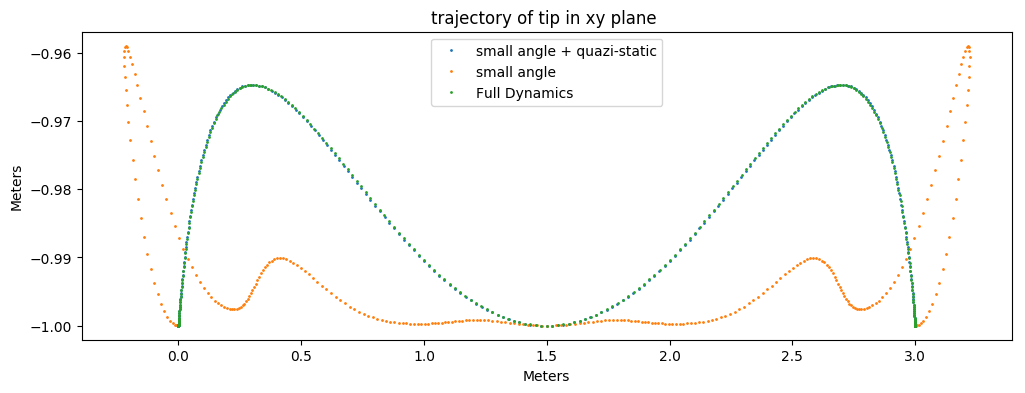

PyObject <matplotlib.legend.Legend object at 0x000000005A1195C0>

In [295]:
#plot the resulting tip trajectory
figure(figsize=(12,4))
plotTipTraj(x1)
plotTipTraj(x2)
plotTipTraj(x3)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ])



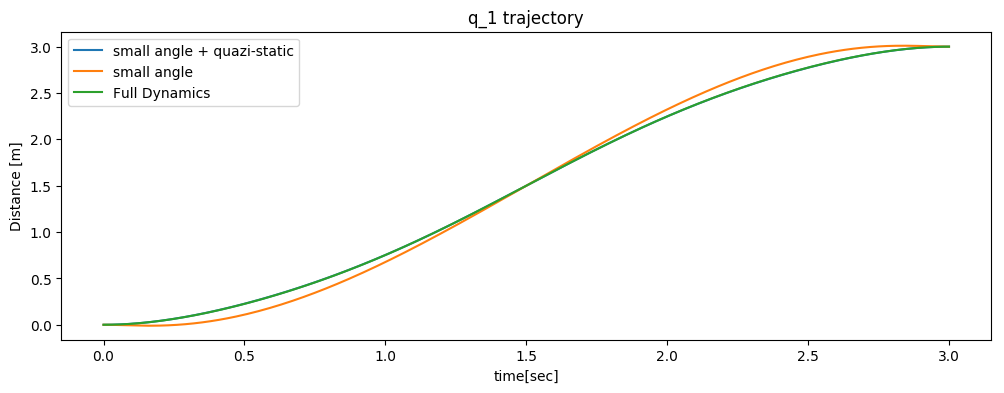

PyObject <matplotlib.legend.Legend object at 0x0000000053BC4DD8>

In [253]:
#plot q1 vs. time
figure(figsize=(12,4)) 
plotq1(x1,h,tf)
plotq1(x2,h,tf)
plotq1(x3,h,tf)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ])

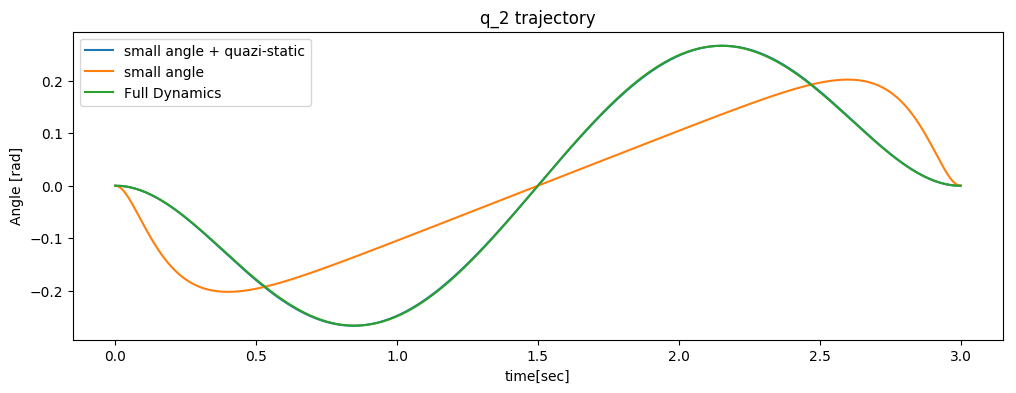

PyObject <matplotlib.legend.Legend object at 0x00000000548853C8>

In [254]:
figure(figsize=(12,4)) 
plotq2(x1,h,tf)
plotq2(x2,h,tf)
plotq2(x3,h,tf)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ])

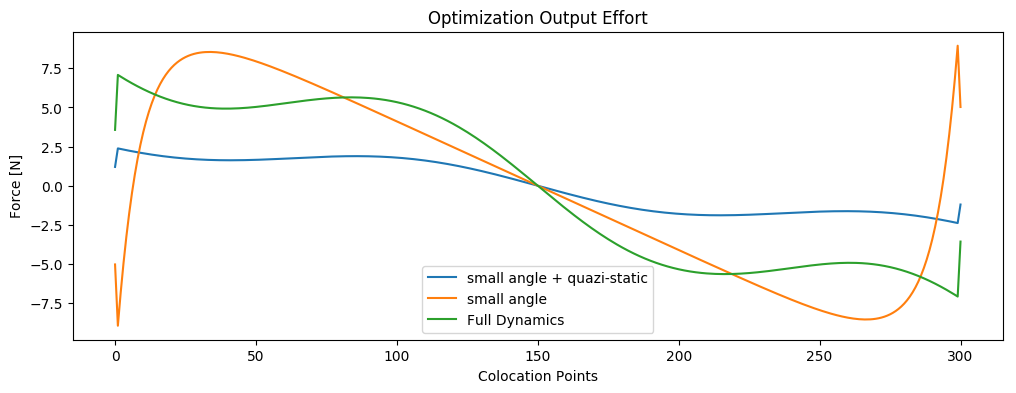

PyObject <matplotlib.legend.Legend object at 0x0000000056681F98>

In [255]:
figure(figsize=(12,4)) 
plotu(u1)
plotu(u2)
plotu(u3)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ])

#### Test Case 2) $x_0 = [0, \pi, 0, 0]'$  ;  $x_f = [3, \pi, 0, 0]'$   

<video controls src=".\gifs\condition2-Finaledit.mp4" />

*visualization of test case 2 performed on full dynamics model*


In this test case, the system is moving about a unstable equalibrium point at $q_2 = \pi$, meaning that any displacement in $q_2$ results in a restoring torque due to gravity. Because the total time execution is long for the given distance (3meters), average velocity of the cart is kept low, and angular deviation of $q_2$ is small. Not only that, but angular velocity of q2 is kept at a minimum. This leads to the prediction that the linearized model, which makes both small angle and quazi-static assumptions, and the intermediate model with makes small angle assumptions should produce accurate results for this test case

In [85]:
#define initial and final states
x0 = [0 pi 0 0]' 
xf = [3 pi 0 0]' 
tf = 3 ; h = .01

#evaluate each model
#u1,x1,xdot1 =  SolvLinearizedCartPole(x0, xf, tf, h ; q2const = true , itype = "Trap")
u2,x2,xdot2 =  SolvNonStaticCartPole(x0, xf, tf, h ; q2const = true,  itype = "Trap")
u3,x3,xdot3 =  SolvFullCartPole(x0, xf, tf, h;  q2const = true, xStart="None" , itype= "Trap");


Academic license - for non-commercial use only


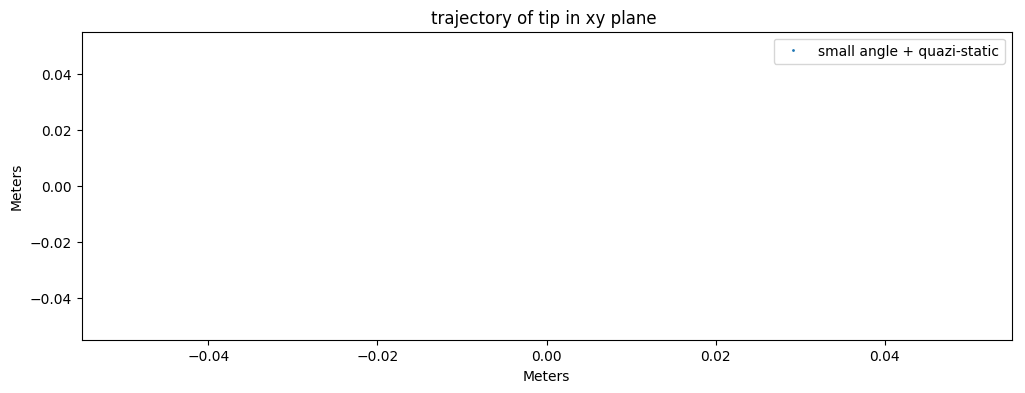

PyObject <matplotlib.legend.Legend object at 0x00000000608D0208>

In [86]:
#plot the resulting tip trajectory
figure(figsize=(12,4))
#plotTipTraj(x1)
plotTipTraj(x2)
#plotTipTraj(x3)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ])



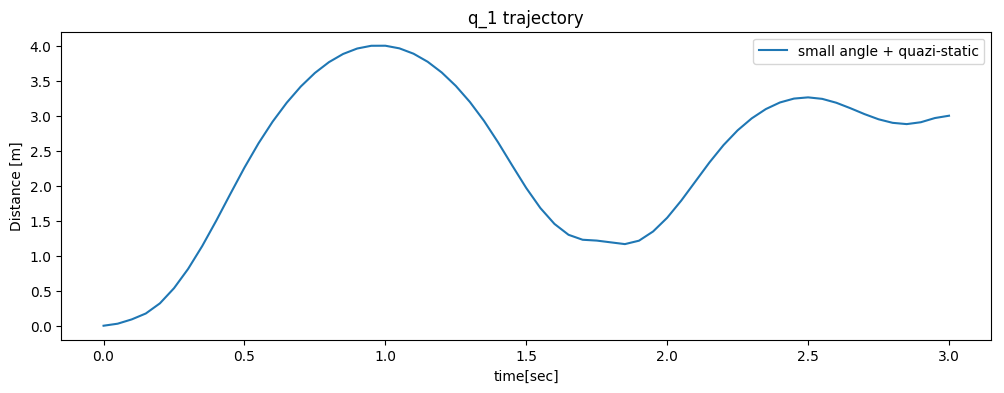

PyObject <matplotlib.legend.Legend object at 0x00000000506352E8>

In [216]:
#plot q1 vs. time
figure(figsize=(12,4)) 
#plotq1(x1,h,tf)
plotq1(x2,h,tf)
#plotq1(x3,h,tf)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ])

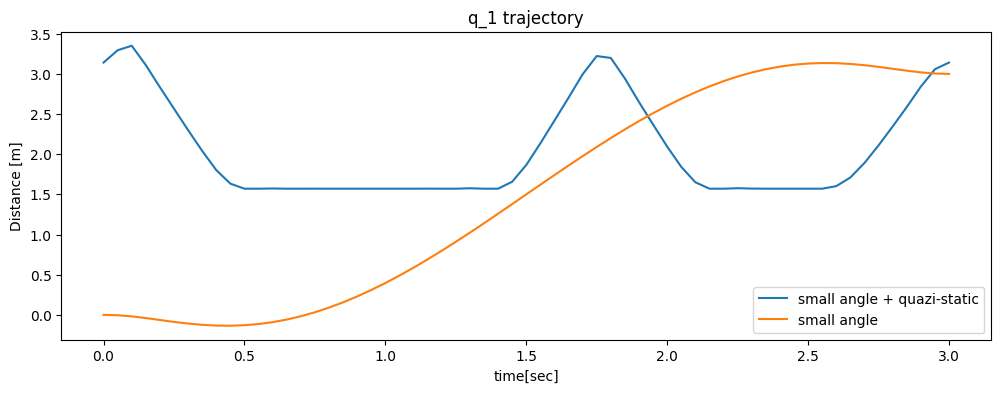

PyObject <matplotlib.legend.Legend object at 0x0000000050959CC0>

In [217]:
#plot q1 vs. time
figure(figsize=(12,4)) 
#plotq2(x1,h,tf)
plotq2(x2,h,tf)
plotq1(x3,h,tf)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ])

#### Test Case 3) $x_0 = [0, 0, 0, 0]'$  ;  $x_f = [3, \pi, 0, 0]'$   

<video controls src=".\gifs\condition3-Finaledit.mp4" />

*visualization of test case 2 performed on full dynamics model*

In the final test case, the system is asked to peform swing-up. Swing-up requires both large angular deviations, and fast angular velocities of $q_2$. This violates both the small angle and quazi-static assumptions, and should to 

of the pendulum in order to impart momentum to the pendulum, perform a counter motion by the cart, and 


In [242]:
#define initial and final states
x0 = [0 0 0 0]' 
xf = [3 pi 0 0]' 
tf = 3 ; h = .01

#evaluate each model
u1,x1,xdot1 =  SolvLinearizedCartPole(x0, xf, tf, h ; q2const = false , itype = "Trap")
u2,x2,xdot2 =  SolvNonStaticCartPole(x0, xf, tf, h ; q2const = false,  itype = "Trap")
u3,x3,xdot3 =  SolvFullCartPole(x0, xf, tf, h;  q2const = false, xStart="None" , itype= "Trap");

Academic license - for non-commercial use only


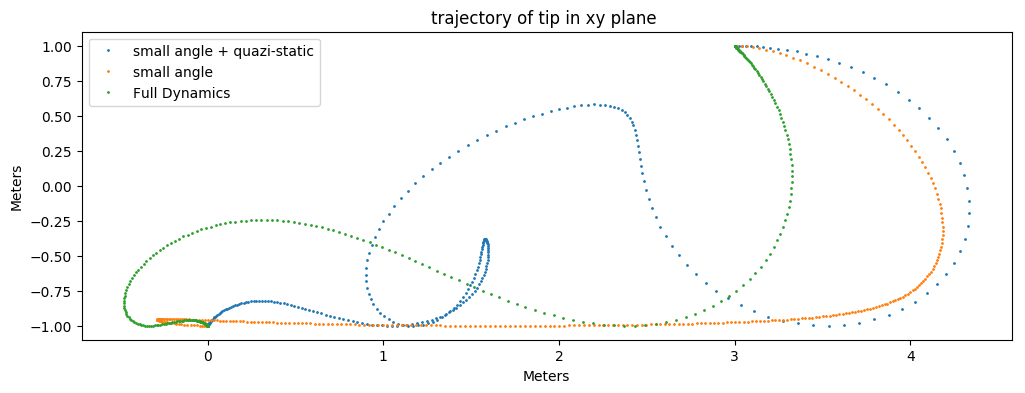

PyObject <matplotlib.legend.Legend object at 0x0000000051B67630>

In [246]:
#plot the resulting tip trajectory
figure(figsize=(12,4))
plotTipTraj(x1)
plotTipTraj(x2)
plotTipTraj(x3)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ]);


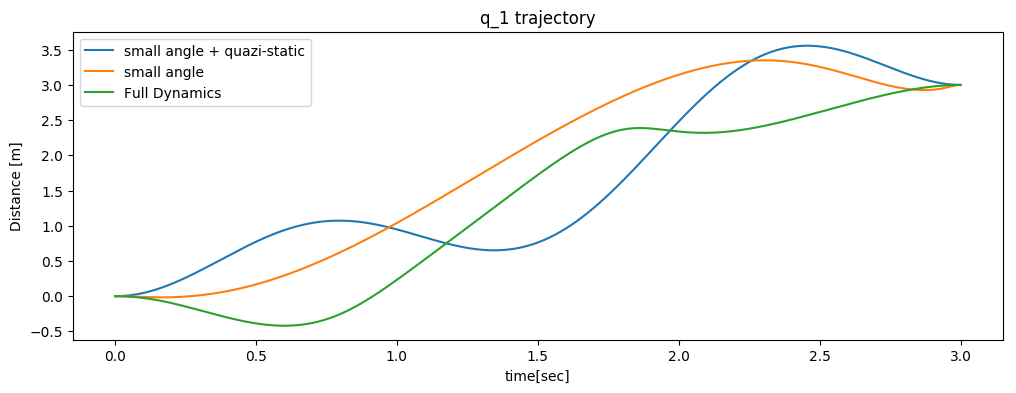

PyObject <matplotlib.legend.Legend object at 0x000000004945BFD0>

In [227]:
#plot q1 vs. time
figure(figsize=(12,4)) 
plotq1(x1,h,tf)
plotq1(x2,h,tf)
plotq1(x3,h,tf)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ]);

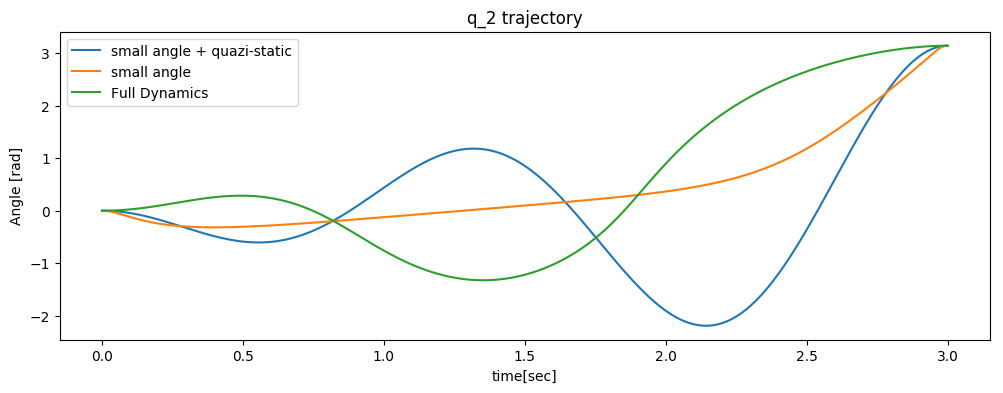

PyObject <matplotlib.legend.Legend object at 0x00000000494E6E10>

In [228]:
figure(figsize=(12,4)) 
plotq2(x1,h,tf)
plotq2(x2,h,tf)
plotq2(x3,h,tf)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ])

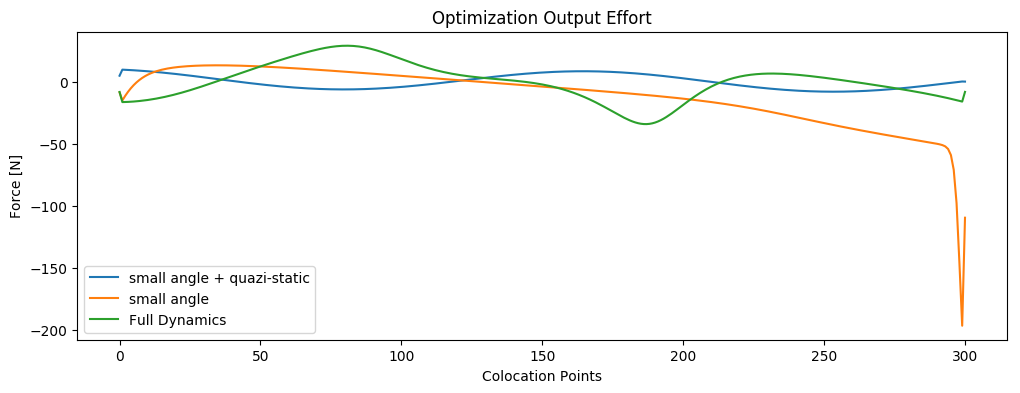

PyObject <matplotlib.legend.Legend object at 0x000000004A24E9E8>

In [229]:
figure(figsize=(12,4)) 
plotu(u1)
plotu(u2)
plotu(u3)
legend(["small angle + quazi-static","small angle", "Full Dynamics" ])

# Results and Discussion <a class="anchor" id="1RD"></a>


# Experimentation with Full Dynamics <a class="anchor" id="2"></a>

The full dynamic model is the most accurate model in the widest range of circumstances at the cost of solution time. It is interesting to see how it behaves in different circumstances for example if the pendulum had to avoid an obstical during swing up. 

### Obsticle Avoidance With Hard Constraints <a class="anchor" id="2aa"></a> 
Another approach to obstacle avoidance is to use explicit constraints. The approach constraints the solution to a space outside an ellipse which is placed around the object. The quadratic constraint is implemented for each of the colocation points constraining the mass of the pendulum from entering the designated area at any point in time.

The form of the constraint implemented at each colocation point is:

$$ \frac{(x + x_off)^2}{a^2} + \frac{(y + y_off)^2}{b^2} >= 1 $$

### Standard Form

\begin{aligned}
\underset{\mathbf{x},\mathbf{\dot x},\mathbf{u}_i \in \mathbb{R^2}}{\text{minimize}}\qquad& \sum_{i=1}^{n}u_i^2\\
\text{subject to:}\qquad & {x_{1}} - {x}_{initial} = 0 \\
& {\dot{x_{k}}} - {\dot{x}}_{final} = 0 && \\
& \ddot q_1 - \frac{lm_2sin(q_2)\dot q_2^2 + u + m_2gcos(q_2)sin(q_2)}{m_1 + m_2(1-cos^2(q_2))} = 0 && \forall k \in \{1,\dots,N\}\\
& \ddot q_2 + \frac{lm_2cos(q_2)sin(q_2)\dot q_2^2 + ucos(q_2) + (m_1+m_2)gsin(q_2)}{lm_1 + lm_2(1-cos^2(q_2))} =  0 && \forall k \in \{1,\dots,N\}\\
&  \frac{((q_1 + lsin(q_2))-x_off) + x_off)^2}{a^2} + \frac{((-lcos(q_2))) + y_off)^2}{b^2} - 1 >= 0 && \forall k \in \{1,\dots,N\}\\
& {x}_{k+1} - {x}_{k} - 0.5 h ({\dot x}_{k} +{\dot x}_{k+1}) = 0 && \forall k \in \{1,\dots,N-1\}\\
& \text{where:}\\
& \begin{equation}
 x =
 \begin{bmatrix}
  q_1 \\ q_2 \\ \dot{q_1} \\ \dot{q_2}
\end{bmatrix}	
\qquad \text{and} \qquad 		
\dot{x} = f ( x , u ) =
\begin{bmatrix}
\dot{q_1} \\ \dot{q_2} \\ \ddot{q_1} \\ \ddot{q_2}
\end{bmatrix}
\end{equation}
\end{aligned}

In [93]:
using JuMP, PyPlot, Ipopt

#define initial and final states, x
x0 = [0 0 0 0]' 
xf = [3 pi 0 0]'   #wind up at the same angle, but 

"""
solve the cart pull problem using direct collocation and full dynamics

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolvFullCartPullObstical(x0, xf, tf, h, a, b, c, xoff, yoff, itype = "backwardEuler")
    
    #define model
    m = Model(solver = IpoptSolver(print_level=0))
    T = 0:h:tf                   #time vector
    K = length(T)                 #number of collocation points
    @variable(m,    x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)
    
    #constraints on the total cart range
    @constraint(m, x[1,:] .<= 4)
    @constraint(m,-6 .<= x[1,:])

    
    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    
    
        # Elypse constraint on the mass location
    for i = 1:K
        @NLconstraint(m, ((x[1,i] + l*sin(x[2,i])) - xoff)^2/a^2 + ((-l*cos(x[2,i])) - yoff)^2/b^2 >= c )
    end
    
    #setup the full dynamics constraints
    for k in 1:K
        @constraint(m,xdot[1,k] == x[3,k])                      #this step could be wrong!!! I may need to integrate here
        @constraint(m,xdot[2,k] == x[4,k])                      #look here for an issue
         #calculate xdot    
        q1 = x[1,k] ; q2 = x[2,k] ; q1dot = x[3,k] ; q2dot = x[4,k]
        @NLconstraint(m,xdot[3,k] ==  (l*m2*sin(q2)*q2dot^2 + u[1,k] + m2*g*cos(q2)*sin(q2)) /
                                    (m1 + m2*(1-cos(q2)^2)))
        @NLconstraint(m,xdot[4,k] == -(l*m2*cos(q2)*sin(q2)*q2dot^2 + u[1,k]*cos(q2) + (m1 + m2)*g*sin(q2))/
                                    (l*m1 + l*m2*(1-cos(q2)^2)))

    end
    

    if itype == "forwardEuler" 
        #add forward euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + h*xdot[:,k])
        end
        
    elseif itype == "backwardEuler"
        for k in 1:K-1
             #add backwards euler dynamics constraint
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end

    # minimize 2-norm (THIS IS LEAST-SQUARES)
    #@objective(m, Min, .5*h*sum(u[1:end-1].^2 + u[2:end].^2))
    @objective(m, Min, sum(u.^2) ) #+ sum(x[2,:]).^2))
    solve(m)
    #print(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    return ( m, control, xopt, xdotopt)
end


SolvFullCartPullObstical

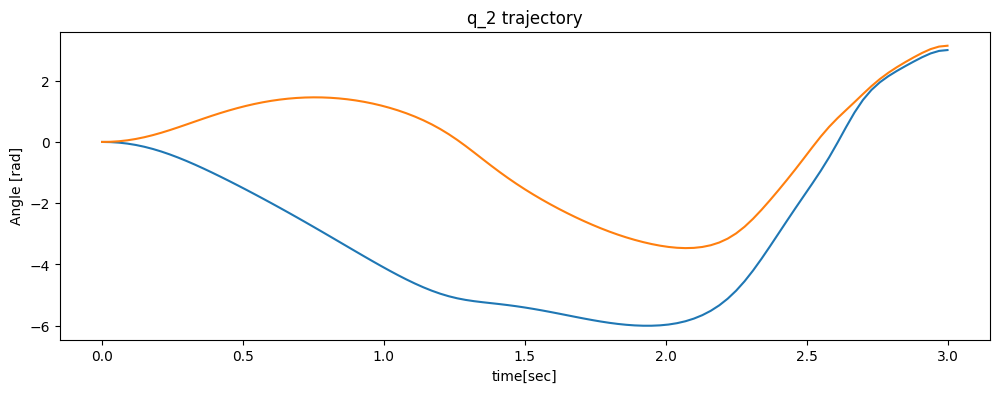

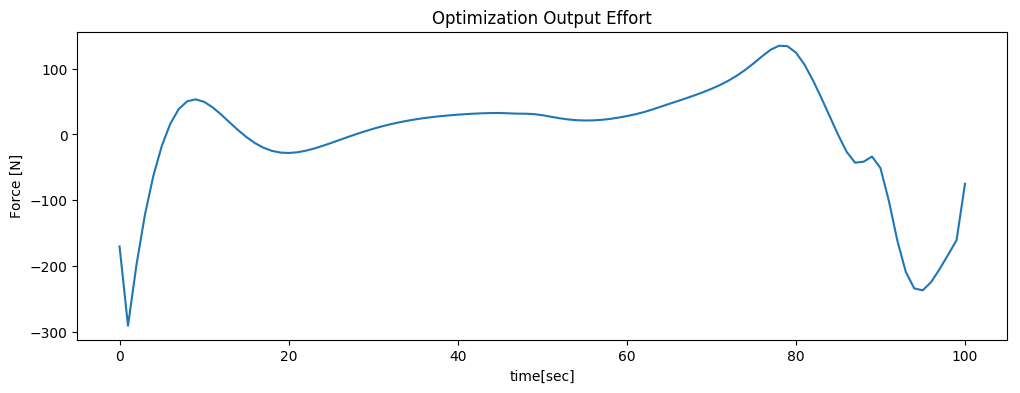

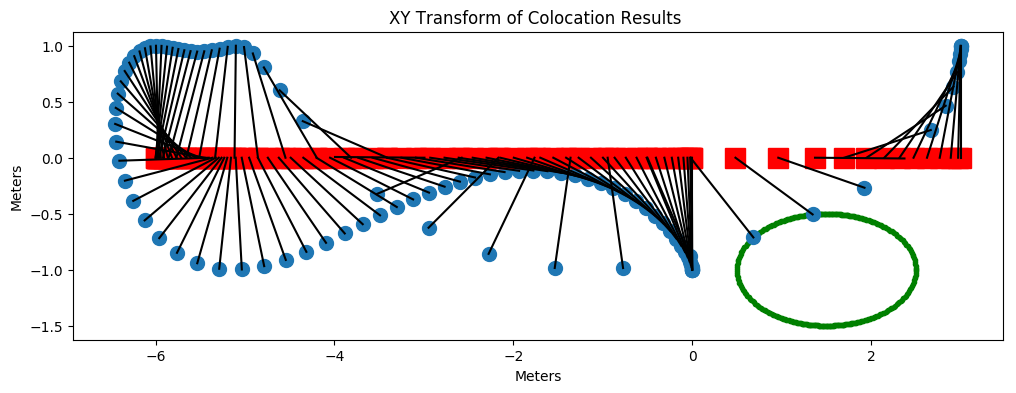

In [105]:
# Elipse Constarint Paramaters
a = 1
b = 0.5
c = 1
xoff = 1.5
yoff = -1
tf = 3 ; h = .03

(m, c, x, xdot) = SolvFullCartPullObstical(x0,xf,tf,h, a, b, c, xoff, yoff)
figure(figsize=(12,4))
plotq1(x,h,tf)
plotq2(x,h,tf)
figure(figsize=(12,4))
plotu(u,h,tf)
figure(figsize=(12,4))
plotEllipse(a,b,c,xoff,yoff) 
plotXY(x)


The Q space optimization plot shows the carts position and the angle of the pendulum at each colocation point. As expected the cart and the pendulum ends up in the desired position. However, the optimal trajectory is achieved by reversing first allowing the cart more room to avoid the obstacle. The effort plot shows the maximum cart force is needed slow the pendulum as it aproaches its vertical position. This result is consistent with the full dynamics used in this simulation. Finally the XY transform of colocation results shows how the pendulum is able to avoid the obstacle plotted in green.

This method of object avoidance is useful because it is fairly generic, multiple constraints can be used, and the generated trajectories closely match the real life dynamics of the system. However, nonlinear constraints add complexity to the model and increase solution times. For this solution to implement properly an additional nonlinear constraint must be added for each colocation point, in this case 100 additional constraints per object.

### Obsticle Avoidance With Regularization <a class="anchor" id="2ab"></a> 
One approach to obstacle avoidance is to include a "soft constraint" by including regularization in the objective function. The following function was used to represent the area around an obstical.

$$ z = \frac{1}{2\pi\sigma^2}e^-[\frac{(x-x_off)^2 + (y-y_off)^2}{2\sigma^2}] $$

A plot visualizing the function used in this section is shown below:

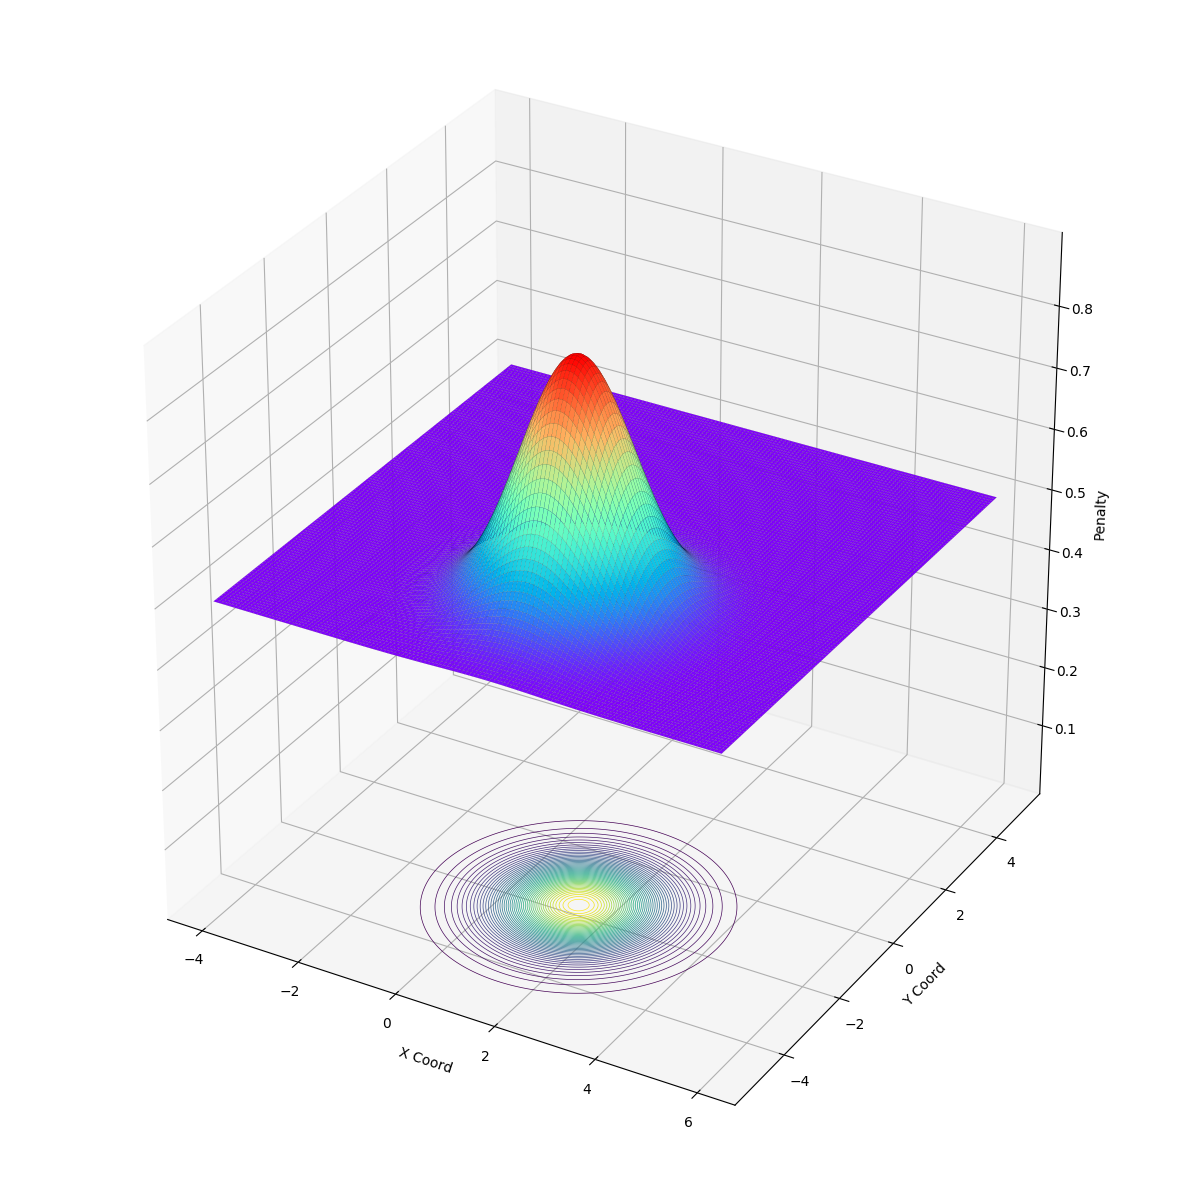

In [38]:
xv = linspace(-4,6,1000)
yv = linspace(-5,5,1000)
xoff = 1.5
yoff = -2
sig = 1

# swap x and y to obtain standard coordinates
z = [1/(sqrt(2*pi*sig^2))*exp(-((x-xoff)^2 + (y-yoff)^2)/(2*sig^2)) for y in yv, x in xv]

function meshgrid{T}(vx::AbstractVector{T}, vy::AbstractVector{T})
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    (repmat(vx, m, 1), repmat(vy, 1, n))
end
(X,Y) = meshgrid(xv,yv);

pygui(false)
figure(figsize=(12,12))
surf(X,Y, z+0.5, rstride=8, cstride=8,cmap="rainbow",edgecolor="black", linewidths=.05)
contour(X, Y, z, zdir="z", 60, offset=0, origin="lower", linewidths=.5 )
xlabel("X Coord"); ylabel("Y Coord"); zlabel("Penalty");
tight_layout()

The function penalizes the objective function centered at the point $ (x_off,y_off) $ and promotes a solutions further away from the object. The objective function, with regularization included and in terms of $q_1$ and $q_2$, takes the form of the following equation.

$$ \sum(u^2) + \lambda \sum \frac{1}{2\pi\sigma^2}e^-[\frac{(x-x_off)^2 + (y-y_off)^2}{2\sigma^2}] $$

### Standard Form
\begin{aligned}
\underset{\mathbf{x},\mathbf{\dot x},\mathbf{u}_i \in \mathbb{R^2}}{\text{minimize}}\qquad& \sum_{i=1}^{n}u_i^2 + \lambda \sum_{i=1}^{n} \frac{1}{2\pi\sigma^2}e^-[\frac{((q_1 + lsin.(q_2))-x_off)^2 + ((-lcos.(q_2))-y_off)^2}{2\sigma^2}]\\
\text{subject to:}\qquad & {x_{1}} - {x}_{initial} = 0 \\
& {\dot{x_{k}}} - {\dot{x}}_{final} = 0 && \\
& \ddot q_1 - \frac{lm_2sin(q_2)\dot q_2^2 + u + m_2gcos(q_2)sin(q_2)}{m_1 + m_2(1-cos^2(q_2))} = 0 && \forall k \in \{1,\dots,N\}\\
&  \ddot q_2 + \frac{lm_2cos(q_2)sin(q_2)\dot q_2^2 + ucos(q_2) + (m_1+m_2)gsin(q_2)}{lm_1 + lm_2(1-cos^2(q_2))} =  0 && \forall k \in \{1,\dots,N\}\\
& {x}_{k+1} - {x}_{k} - 0.5 h ({\dot x}_{k} +{\dot x}_{k+1}) = 0 && \forall k \in \{1,\dots,N-1\}\\
& \text{where:}\\
& \begin{equation}
 x =
 \begin{bmatrix}
  q_1 \\ q_2 \\ \dot{q_1} \\ \dot{q_2}
\end{bmatrix}	
\qquad \text{and} \qquad 		
\dot{x} = f ( x , u ) =
\begin{bmatrix}
\dot{q_1} \\ \dot{q_2} \\ \ddot{q_1} \\ \ddot{q_2}
\end{bmatrix}
\end{equation}
\end{aligned}

In [70]:
using JuMP, PyPlot, Ipopt

#define initial and final states, x
x0 = [0 0 0 0]' 
xf = [3 pi 0 0]'   #wind up at the same angle, but 

"""
solve the cart pull problem using direct collocation and full dynamics

inputs:
    x0 = [q₁ q₂ q₁dot q₂dot]'      #initial system state
    xf = [q₁ q₂ q₁dot q₂dot]'      #final system state
    tf = [sec]                     #time to get to final state
    h =  [sec]                     #time between collocation points

outputs:
    path = [4xk]                   #state matrix that specifies path 
"""
function SolveRegularizedCartPull(x0, xf, tf, h, xoff, yoff, y, itype = "backwardEuler")
    
    #define model
    m = Model(solver = IpoptSolver(print_level=0))
    T = 0:h:tf                   #time vector
    K = length(T)                 #number of collocation points
    @variable(m,    x[1:4,1:K])   #system state at discrete times
    @variable(m, xdot[1:4,1:K])   #derivative of system state at discrete times
    @variable(m,    u[1:1,1:K])   #control input to system along q1

    #boundry constraints - initial and final state
    @constraint(m, x[:,1] .== x0)
    @constraint(m, x[:,K] .== xf)
    
    #constraints on the total cart range
    @constraint(m, x[1,:] .<= 4)
    @constraint(m,-6 .<= x[1,:])
    
    #model constants
    l = 1         #length of arm
    m1 = 3        #mass of cart
    m2 = 1        #mass of pendulum point mass
    g = 9.81
    
    #setup the full dynamics constraints
    for k in 1:K
        @constraint(m,xdot[1,k] == x[3,k])                      #this step could be wrong!!! I may need to integrate here
        @constraint(m,xdot[2,k] == x[4,k])                      #look here for an issue
         #calculate xdot    
        q1 = x[1,k] ; q2 = x[2,k] ; q1dot = x[3,k] ; q2dot = x[4,k]
        @NLconstraint(m,xdot[3,k] ==  (l*m2*sin(q2)*q2dot^2 + u[1,k] + m2*g*cos(q2)*sin(q2)) /
                                    (m1 + m2*(1-cos(q2)^2)))
        @NLconstraint(m,xdot[4,k] == -(l*m2*cos(q2)*sin(q2)*q2dot^2 + u[1,k]*cos(q2) + (m1 + m2)*g*sin(q2))/
                                    (l*m1 + l*m2*(1-cos(q2)^2)))

    end
    

    if itype == "forwardEuler" 
        #add forward euler dynamics constraint
        for k in 1:K-1
            @constraint(m, x[:,k+1] .== x[:,k] + h*xdot[:,k])
        end
        
    elseif itype == "backwardEuler"
        for k in 1:K-1
             #add backwards euler dynamics constraint
            @constraint(m, x[:,k+1] .== x[:,k] + .5*h*(xdot[:,k] + xdot[:,k+1]))
        end     
    end

    #xCordM = x[1,:] + l*sin.(x[2,:])
    #yCordM = -l*cos.(x[2,:])
    
    # minimize 2-norm (THIS IS LEAST-SQUARES)

    @NLexpression(m, reg[1,i=1:K],  1/(sqrt(2*pi*sig^2))*exp(-((((x[1,i] + l*sin(x[2,i]))-xoff)^2 + (-l*cos(x[2,i])-yoff)^2)/(2*sig^2))) ) 
    @NLobjective(m, Min, sum(u[j]^2 + y*reg[1,j] for j=1:K) ) 
    solve(m)
    #print(m)
    
    control = getvalue(u)
    xopt = getvalue(x)
    xdotopt = getvalue(xdot)
    
    return (m, control, xopt, xdotopt)
end

SolveRegularizedCartPull

### Solution: Avoiding Obsticals with Soft Constraints

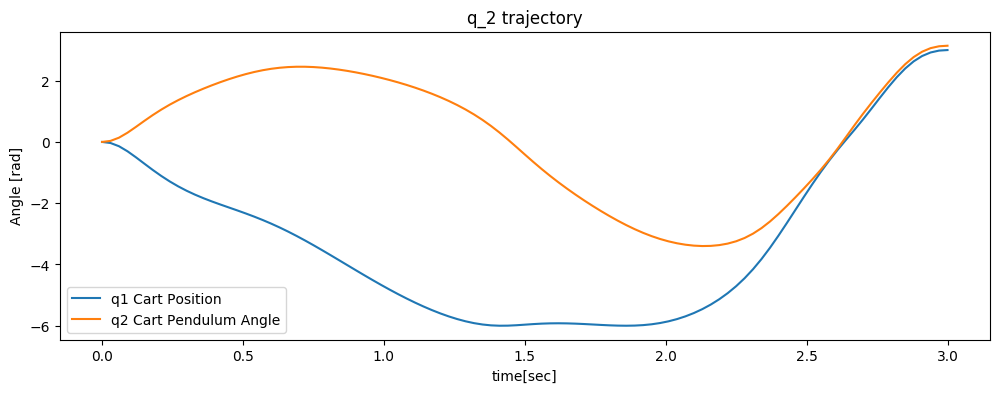

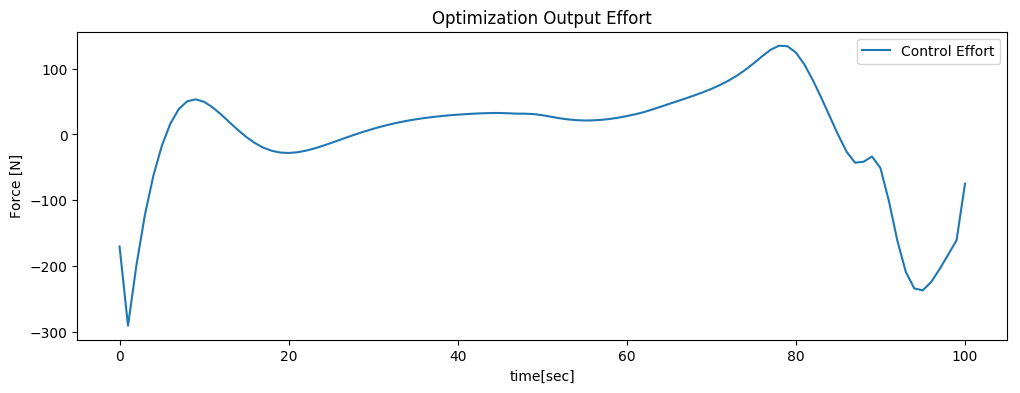

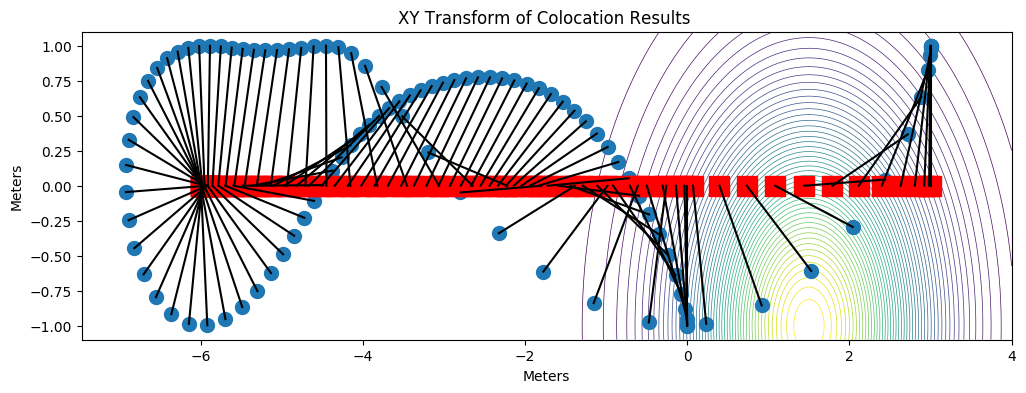

PyObject <matplotlib.contour.QuadContourSet object at 0x00000000A8903E48>

In [106]:
y = 1000000
xoff = 1.5
yoff = -1
tf = 3 ; h = .03

(m, u, x, xdot) = SolveRegularizedCartPull( x0, xf, tf, h, xoff, yoff, y)
figure(figsize=(12,4))
plotq1(x,h,tf)
plotq2(x,h,tf)
legend(["q1 Cart Position","q2 Cart Pendulum Angle"])
figure(figsize=(12,4))
plotu(u,h,tf)
legend(["Control Effort"])
figure(figsize=(12,4))
plotXY(x)
plotContour(xoff,yoff)

Adjusting lambda allows the optimizer to find a solution that avoids the object placed at $(x_off,y_off) $. A different lambda is needed at different locations to force the optimizer to miss the obstacle. This results in a different pareto front for each possible location of an obstacle. This could be considered a drawback of this technique, because lambda must be re-adjusted each time the object changes location or the trajectory changes inorder to ensure an object is avoided. A different and possibly more effective solution for obstacle avoidance using soft constraints might be obtained by using a different cost function like an inverse function.

# Double Pendulum Swing Up <a class="anchor" id="2b"></a>

# Conclusion <a class="anchor" id="conclusion"></a>

###  timing table
